In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 


import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import norm, skew
from statsmodels.tsa.stattools import adfuller
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import itertools

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\BS-670\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_excel('product data.xlsx') 

In [3]:
df.head() 

,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,id,ProductKey.1,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductSize,ProductStyle,ProductCost,ProductPrice
0,2015-01-01 00:00:00,9/21/2001,SO45080,332,14657,1,1,1,1,332,2,BK-R50B-58,"Road-650 Black, 58",Road-650,Value-priced bike with many features of our to...,Black,58,U,413.1463,699.0982
1,2015-01-01 00:00:00,2001-05-12 00:00:00,SO45079,312,29255,4,1,1,2,312,2,BK-R93R-48,"Road-150 Red, 48",Road-150,This bike is ridden by race winners. Developed...,Red,48,U,2171.2942,3578.2700
2,2015-01-01 00:00:00,10/29/2001,SO45082,350,11455,9,1,1,3,350,1,BK-M82B-44,"Mountain-100 Black, 44",Mountain-100,Top-of-the-line competition mountain bike. Per...,Black,44,U,1898.0944,3374.9900
3,2015-01-01 00:00:00,11/16/2001,SO45081,338,26782,6,1,1,4,338,2,BK-R50B-44,"Road-650 Black, 44",Road-650,Value-priced bike with many features of our to...,Black,44,U,413.1463,699.0982
4,2015-02-01 00:00:00,12/15/2001,SO45083,312,14947,10,1,1,5,312,2,BK-R93R-48,"Road-150 Red, 48",Road-150,This bike is ridden by race winners. Developed...,Red,48,U,2171.2942,3578.2700


In [5]:
df.shape

(56046, 20)

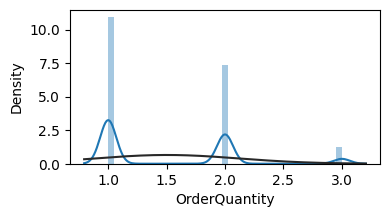

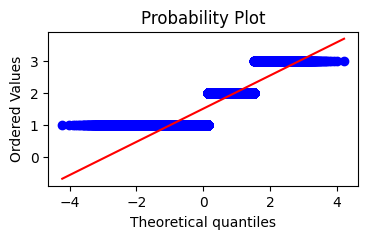

In [7]:
#Lets check the ditribution of the target variable
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sns.distplot(df['OrderQuantity'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['OrderQuantity'], plot=plt)
plt.show()

In [4]:
df['OrderQuantity'].skew()

0.8094057690909564

In [5]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [6]:
df['OrderDate'].min(), df['OrderDate'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2017-12-06 00:00:00'))

In [7]:
monthly_data = df.groupby(['ProductSKU', pd.Grouper(key='OrderDate', freq='MS')])['OrderQuantity'].sum().reset_index()


In [8]:
monthly_data['OrderDate'].min(), monthly_data['OrderDate'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2017-12-01 00:00:00'))

In [9]:
monthly_data.groupby('ProductSKU').agg(
    total_occurrences=('ProductSKU', 'size'),
    total_order_quantity=('OrderQuantity', 'sum')
).sort_values(by='total_occurrences', ascending=False).to_csv('products_total_quantity.csv', index = True)

In [10]:
product_ids = ['BK-M68B-42', 'BK-M68S-46', 'BK-M68S-38', 'BK-M68B-46', 'BK-M68B-38']
selected_products = monthly_data[monthly_data['ProductSKU'].isin(product_ids)]

In [11]:
selected_products.shape[0]

176

In [12]:
selected_products['OrderDate'].min(), selected_products['OrderDate'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2017-12-01 00:00:00'))

In [13]:
selected_products.head()

,ProductSKU,OrderDate,OrderQuantity
316,BK-M68B-38,2015-01-01,3
317,BK-M68B-38,2015-02-01,1
318,BK-M68B-38,2015-03-01,2
319,BK-M68B-38,2015-05-01,1
320,BK-M68B-38,2015-06-01,3


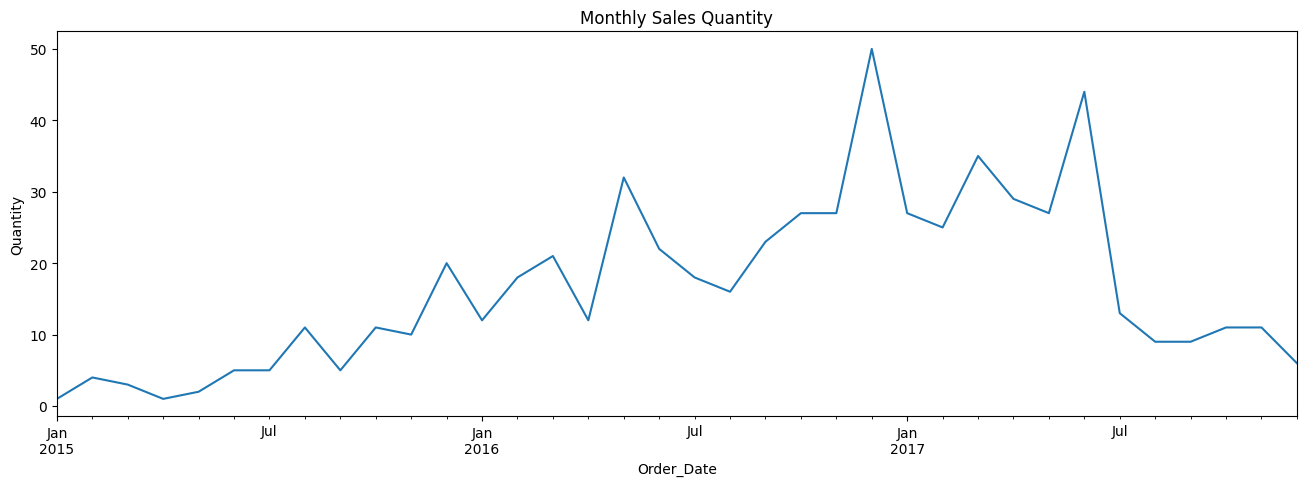

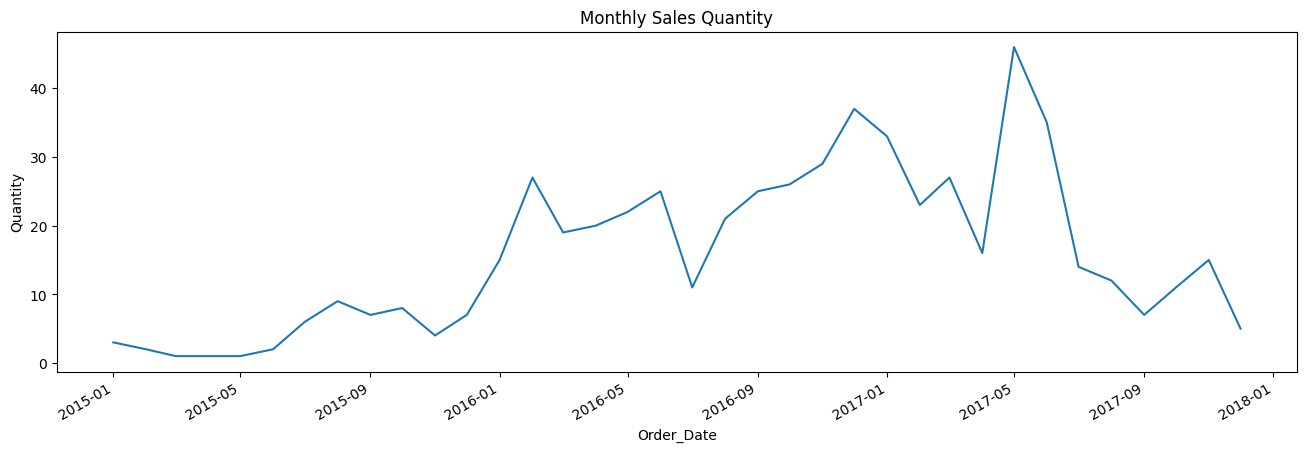

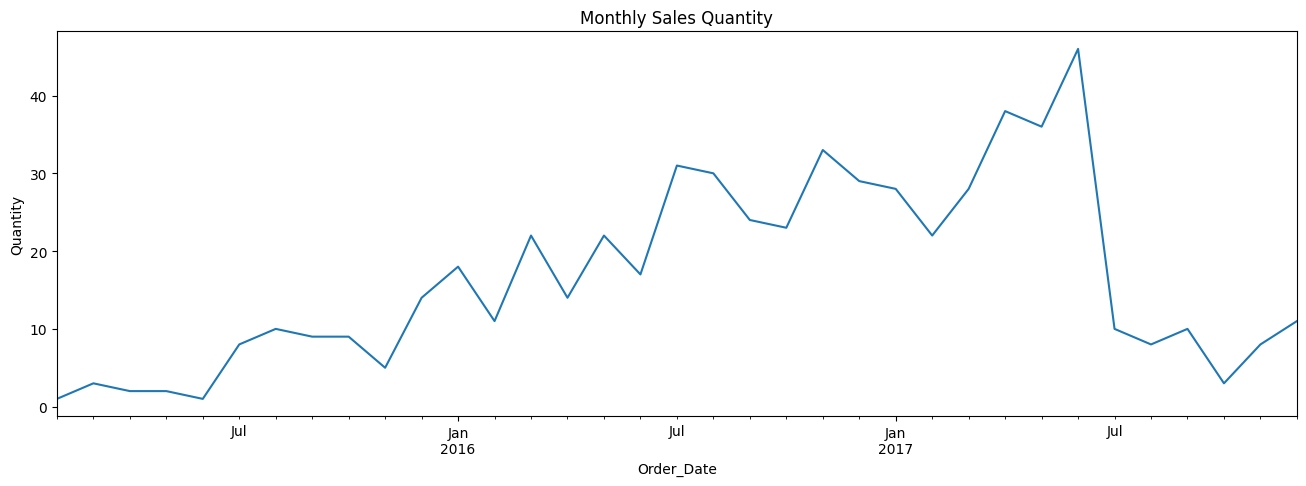

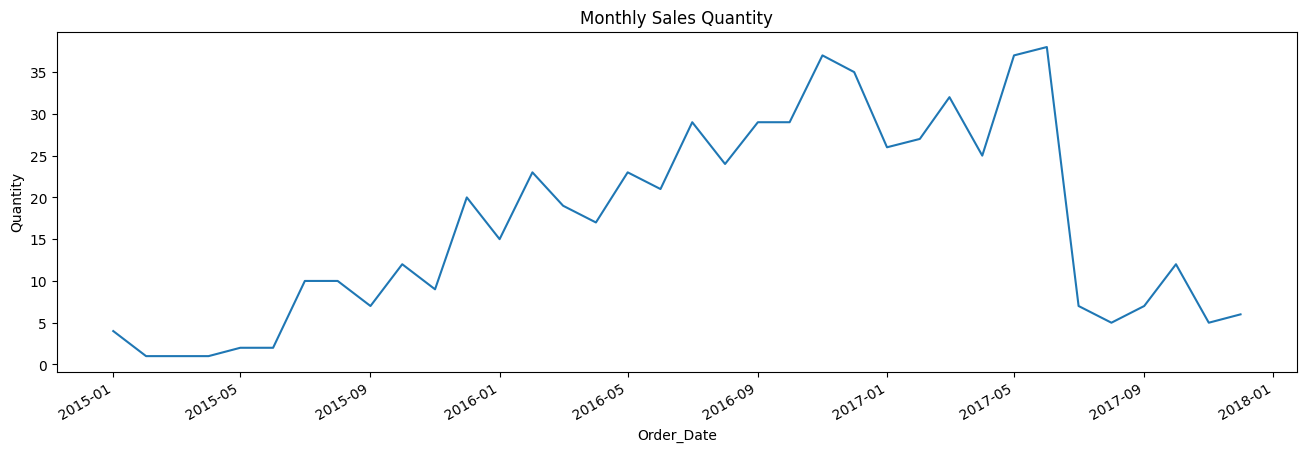

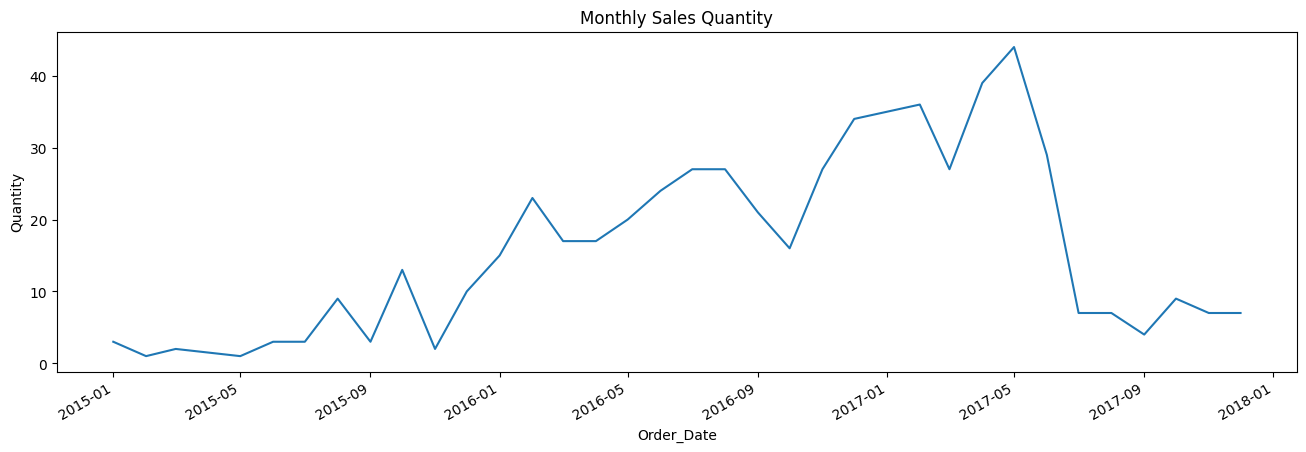

In [14]:
for product in product_ids:
    data = monthly_data[monthly_data['ProductSKU'] == product] 
    data.set_index('OrderDate', inplace = True)
    monthly_graph = data['OrderQuantity'].plot(figsize = (16,5), title="Monthly Sales Quantity")
    monthly_graph.set(xlabel='Order_Date',ylabel='Quantity')
    plt.show()
    

In [15]:
selected_products = selected_products[selected_products['OrderDate'] <= '2017-04-30']

In [ ]:
selected_products

In [86]:
len(selected_products)/5

92.4

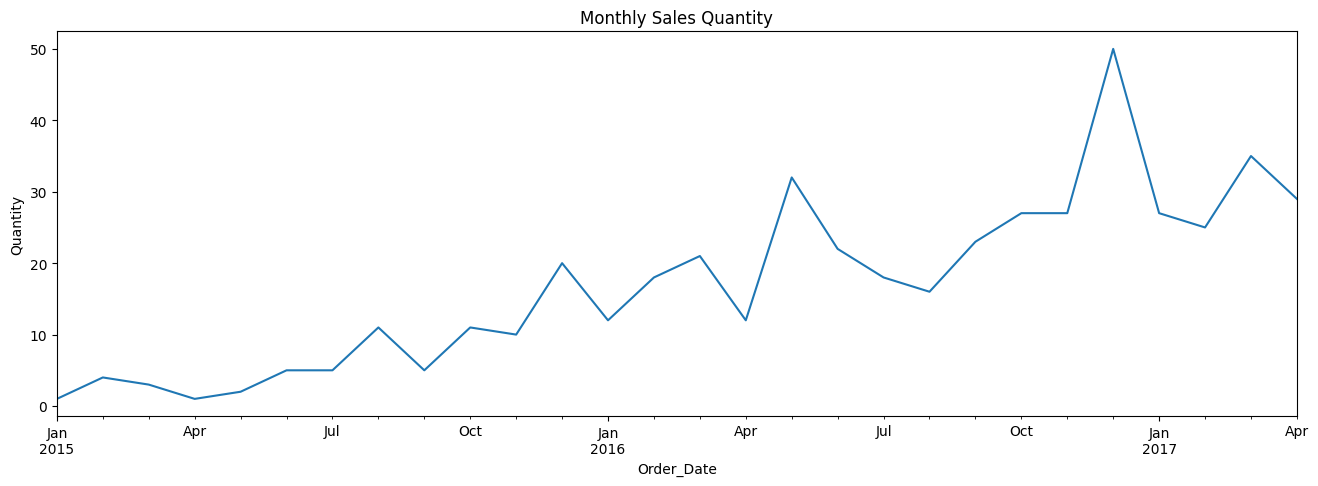

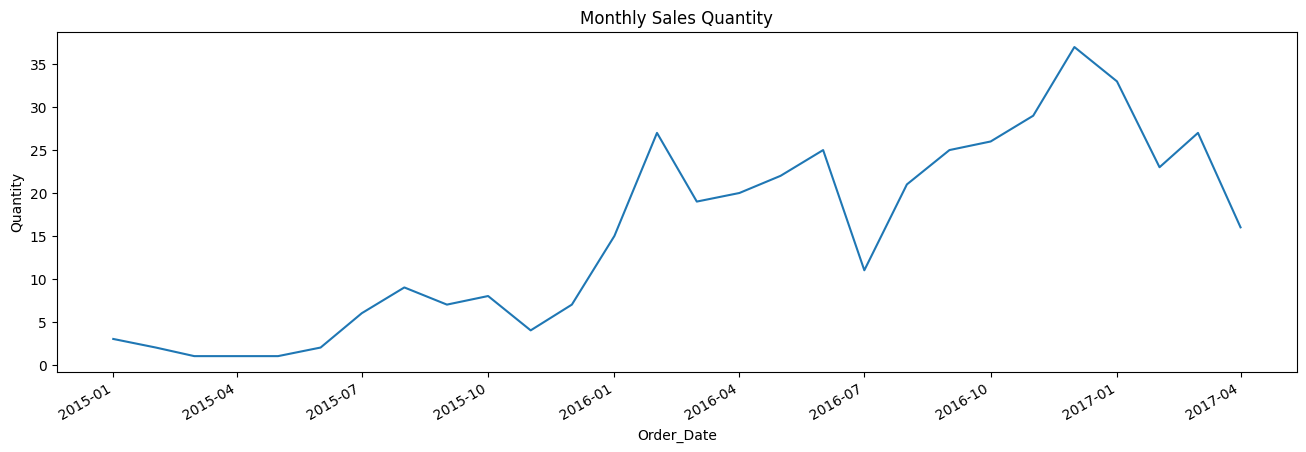

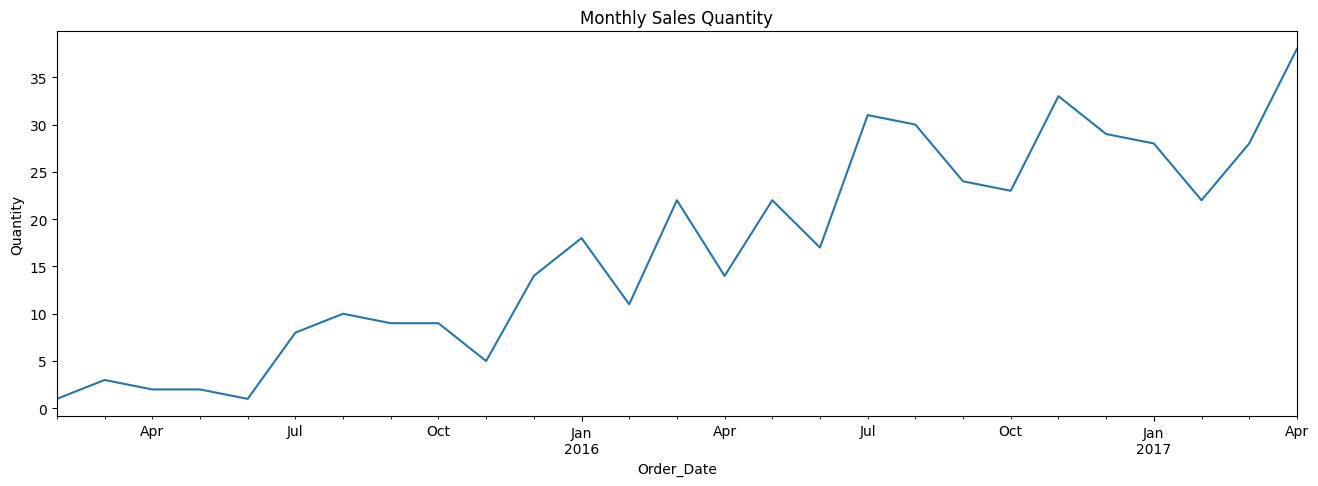

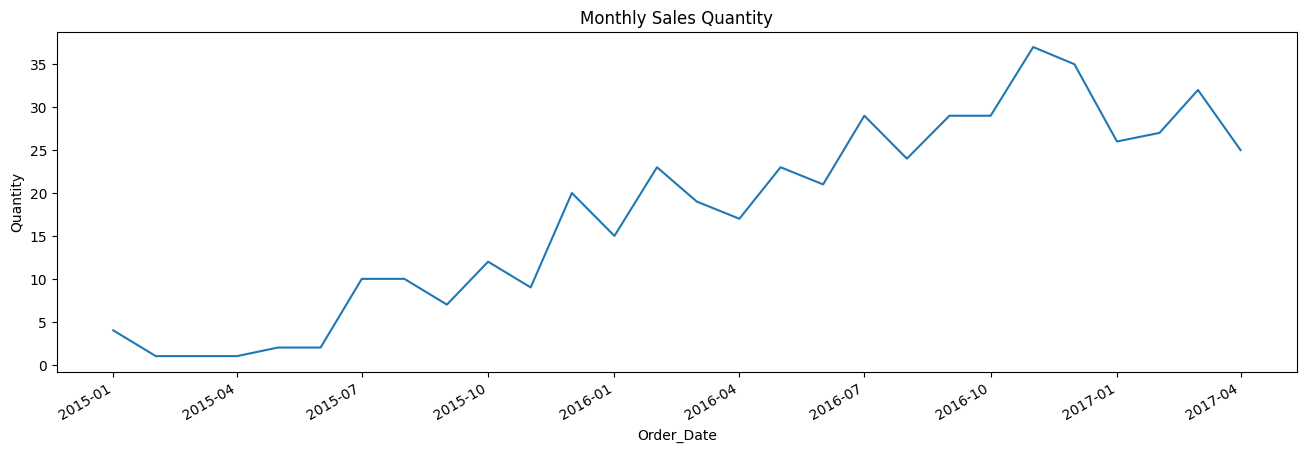

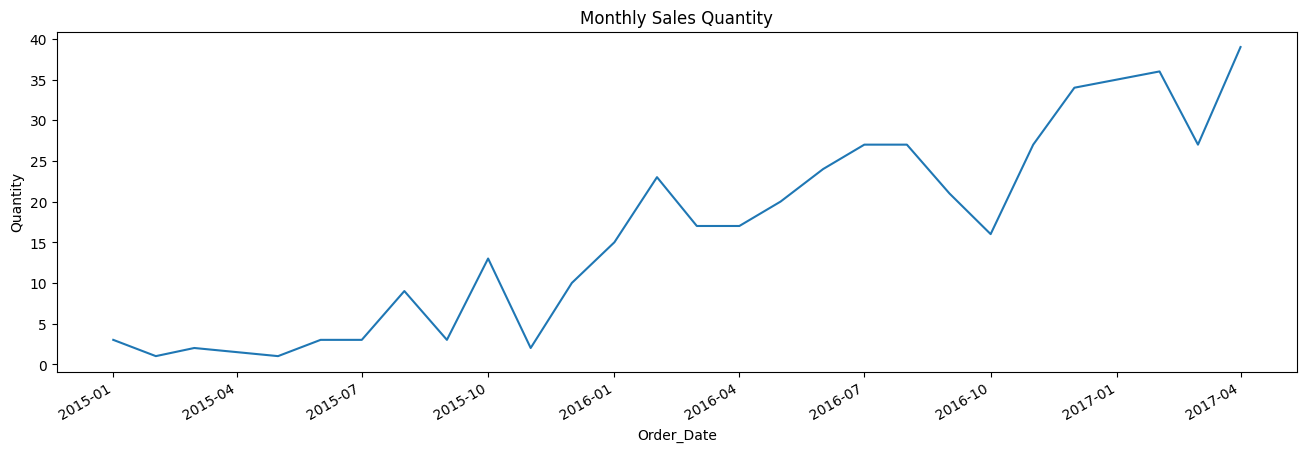

In [16]:
for product in product_ids:
    data = selected_products[selected_products['ProductSKU'] == product] 
    data.set_index('OrderDate', inplace = True)
    monthly_graph = data['OrderQuantity'].plot(figsize = (16,5), title="Monthly Sales Quantity")
    monthly_graph.set(xlabel='Order_Date',ylabel='Quantity')
    plt.show()
    

In [17]:
selected_products.head()

,ProductSKU,OrderDate,OrderQuantity
316,BK-M68B-38,2015-01-01,3
317,BK-M68B-38,2015-02-01,1
318,BK-M68B-38,2015-03-01,2
319,BK-M68B-38,2015-05-01,1
320,BK-M68B-38,2015-06-01,3


### Start

In [66]:
data = selected_products[selected_products['ProductSKU'] == 'BK-M68B-42'] 
data = data.drop('ProductSKU', axis = 1).set_index('OrderDate')

In [67]:
# log_transformed_series = np.log(data['OrderQuantity'])

data['log_sales'] = np.log(data['OrderQuantity'])

# Step 5: Differencing to Remove Trend
# data['log_sales_diff'] = data['log_sales'].diff().dropna()



data['lag1'] = data['log_sales'].shift(1)
data['rolling_mean'] = data['log_sales'].rolling(window=3).mean()

data = data.dropna()

In [68]:
data

,OrderQuantity,log_sales,lag1,rolling_mean
OrderDate,,,,
2015-03-01,3,1.098612,1.386294,0.828302
2015-04-01,1,0.000000,1.098612,0.828302
2015-05-01,2,0.693147,0.000000,0.597253
2015-06-01,5,1.609438,0.693147,0.767528
2015-07-01,5,1.609438,1.609438,1.304008
2015-08-01,11,2.397895,1.609438,1.872257
2015-09-01,5,1.609438,2.397895,1.872257
2015-10-01,11,2.397895,1.609438,2.135076
2015-11-01,10,2.302585,2.397895,2.103306


In [69]:
train_data = data.iloc[:-5]
test_data = data.iloc[-5:]

In [70]:
test_data

,OrderQuantity,log_sales,lag1,rolling_mean
OrderDate,,,,
2016-12-01,50,3.912023,3.295837,3.501232
2017-01-01,27,3.295837,3.912023,3.501232
2017-02-01,25,3.218876,3.295837,3.475579
2017-03-01,35,3.555348,3.218876,3.356687
2017-04-01,29,3.367296,3.555348,3.380507


In [71]:
exog_train = train_data[['lag1', 'rolling_mean']]
exog_test = test_data[['lag1', 'rolling_mean']]


In [72]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12


In [73]:
model = SARIMAX(train_data['log_sales'], order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exog_train)
results = model.fit()

In [74]:
test_predictions = results.get_forecast(steps=len(test_data), exog=exog_test)
pred_mean = predictions.predicted_mean
pred_conf = predictions.conf_int()


In [78]:

pred_mean_final = np.exp(pred_mean)


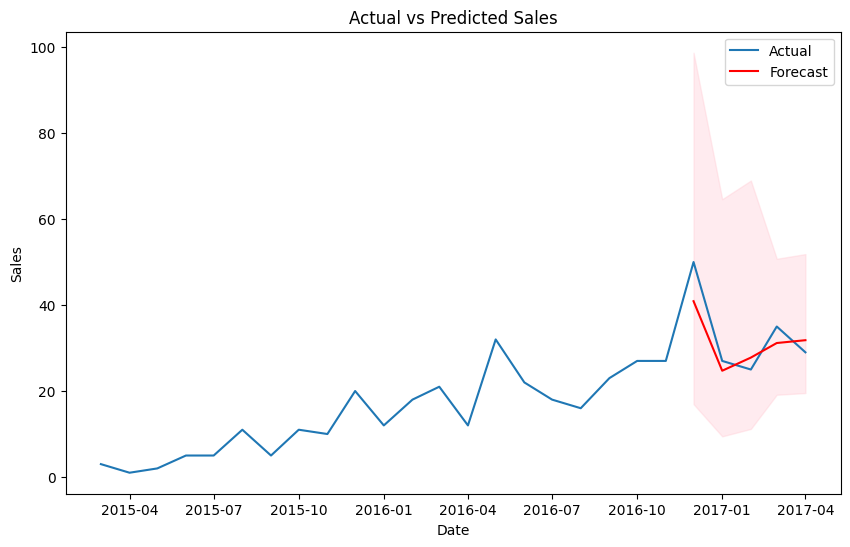

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(data['OrderQuantity'], label='Actual')
plt.plot(pred_mean_final.index, pred_mean_final, label='Forecast', color='red')
plt.fill_between(pred_mean_final.index, np.exp(pred_conf.iloc[:, 0]), np.exp(pred_conf.iloc[:, 1]), color='pink', alpha=0.3)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [81]:
rmse = np.sqrt(mean_squared_error(test_data['log_sales'], pred_mean))
print(f'RMSE: {rmse}')

# Calculate R-squared
r2 = r2_score(test_data['log_sales'], pred_mean)
print(f'R-squared: {r2}')

RMSE: 0.12760321081132864
R-squared: 0.7344765627833627


In [82]:
test_data['OrderQuantity'], pred_mean_final

(OrderDate
 2016-12-01    50
 2017-01-01    27
 2017-02-01    25
 2017-03-01    35
 2017-04-01    29
 Name: OrderQuantity, dtype: int64,
 2016-12-01    40.892149
 2017-01-01    24.719849
 2017-02-01    27.777537
 2017-03-01    31.163769
 2017-04-01    31.820880
 Freq: MS, Name: predicted_mean, dtype: float64)

### END

In [ ]:
for product in product_ids:
    data = selected_products[selected_products['ProductSKU'] == product] 
    data = data.drop('ProductSKU', axis = 1)
    data.set_index('OrderDate', inplace = True)
    
    
    monthly_graph = data['OrderQuantity'].plot(figsize = (16,5), title="Monthly Sales Quantity")
    monthly_graph.set(xlabel='Order_Date',ylabel='Quantity')
    plt.show()

In [88]:
def check_stationarity(st_data):
#     Plot the monthly data
#     plt.figure(figsize=(16, 8))
#     plt.plot(st_data, label='Monthly TotalVolume')
#     plt.title(f'Monthly TotalVolume for ')
#     plt.xlabel('Date')
#     plt.ylabel('TotalVolume')
#     plt.legend()
#     plt.show()
    
    #adfuller test
    result = adfuller(st_data['OrderQuantity'])
#     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#     for value,label in zip(result,labels):
#         print(label+' : '+str(value) )
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    return result[1] <= 0.05

In [89]:
def make_stationary(ts):
    d = 0
    while not check_stationarity(ts):
        ts = ts.diff().dropna()
        d += 1
    return ts, d

In [90]:
def ready_data(df):
    train = pd.DataFrame({
        'OrderDate': df[:int(len(df)*0.8)].index, 
        'OrderQuantity': df[:int(len(df)*0.8)]['OrderQuantity'].values})
    validation = pd.DataFrame({
        'OrderDate': df[int(len(df)*0.8):].index, 
        'OrderQuantity': df[int(len(df)*0.8):]['OrderQuantity'].values})
    return train, validation

In [96]:
def apply_sarimax(train, test):
    p = d = q = P = D = Q = range(0, 3)
    s = [12]  # Seasonal period

    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))

    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(
                    train['OrderQuantity'],
                    exogenous=train[['OrderDate']],
                    order=param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = seasonal_param
            except:
                continue

    # Fit 
    sarimax_model = SARIMAX(
        train['OrderQuantity'],
        exogenous=train[['OrderDate']],
        order=best_params,
        seasonal_order=best_seasonal_params,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = sarimax_model.predict(
        start=len(train),
        end=len(train) + len(test) - 1,
        exogenous=test[['OrderDate']],
        dynamic=False
    )

    rmse = np.sqrt(mean_squared_error(test['OrderQuantity'], forecast))
    r2 = r2_score(test['OrderQuantity'], forecast)

    return r2, rmse, forecast, sarimax_model


In [92]:
def apply_sarimax(train, test):
    # Define SARIMAX model parameters
    
    model_score = {}
    
    order = (1, 1, 1)  # (p, d, q)
    seasonal_order = (1, 1, 1, 12)  # (P, D, Q, s)
    
    # Fit the SARIMAX model
    sarimax_model = SARIMAX(
        train['OrderQuantity'],
        exogenous=train[['OrderDate']],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecasting with SARIMAX model
    forecast = sarimax_model.predict(
        start=len(train), 
        end=len(train) + len(test) - 1,
        exogenous=test[['OrderDate']],
        dynamic=False
    )
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(test['OrderQuantity'], forecast))
    r2 = r2_score(test['OrderQuantity'], forecast)
    
    return r2, rmse, forecast, sarimax_model


120
R2 Score:  -1.4165212381315933e+169 RMSE Score: 1.9893230529580003e+85


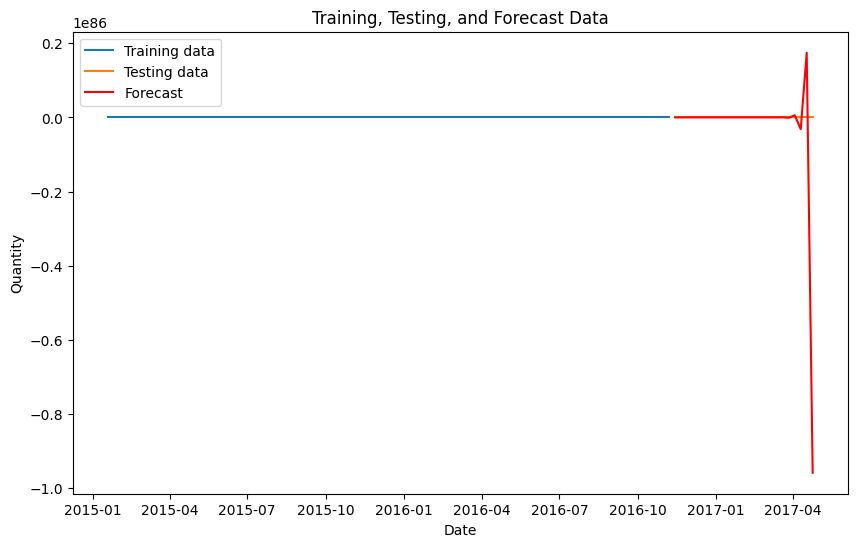

120
R2 Score:  -1.537646767592199e+25 RMSE Score: 22765948314375.617


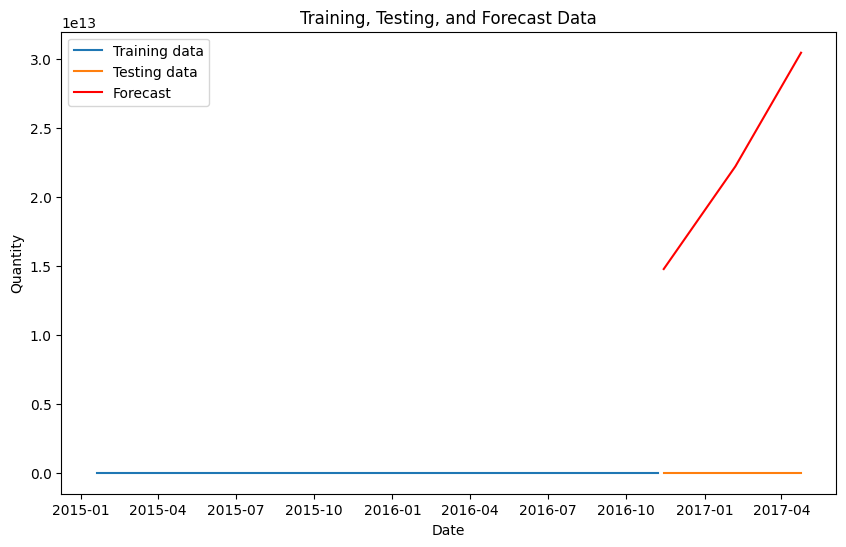

115


In [ ]:

model_score = {}
for product in product_ids:
    data = selected_products[selected_products['ProductSKU'] == product]
    data = data.drop('ProductSKU', axis =1).set_index('OrderDate')
    data = data.resample('W-Mon').sum()
    print(len(data))
    
    if not (check_stationarity(data)):
        data, d = make_stationary(data)
    
    
    train, test = ready_data(data)
    
    r2, rmse, forecast, model = apply_sarimax(train, test)
    model_score[product] = {'r2': r2, 'rmse': rmse, 'model': model}
    
    
    # Plotting 
    print("R2 Score: ", r2, "RMSE Score:", rmse)
    model = model_score[product]['model']
#     forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

    plt.figure(figsize=(10, 6))
    plt.plot(train['OrderDate'], train['OrderQuantity'], label='Training data')
    plt.plot(test['OrderDate'], test['OrderQuantity'], label='Testing data')
    plt.plot(test['OrderDate'], forecast, color='red', label='Forecast')
#     plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('Training, Testing, and Forecast Data')
    plt.legend()
    plt.show()